In [1]:
%load_ext autoreload
%autoreload 2
import os, sys, glob
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import jax
from jax import lax, nn, random
import jax.numpy as jnp
import haiku as hk
import optax
%matplotlib inline

In [2]:
def plot_data(data, x, y, outdir, tag, title, timing=None, smooth=1):
    if smooth > 1:
        """
        smooth data with moving window average.
        that is,
            smoothed_y[t] = average(y[t-k], y[t-k+1], ..., y[t+k-1], y[t+k])
        where the "smooth" param is width of that window (2k+1)
        """
        y = np.ones(smooth)
        for datum in data:
            x = np.asarray(datum[y])
            z = np.ones(len(x))
            smoothed_x = np.convolve(x,y,'same') / np.convolve(z,y,'same')
            datum[y] = smoothed_x
            
    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)
        if timing:
            data = data[data.timing == timing].drop('timing', axis=1)

    if not os.path.isdir(outdir):
        os.mkdir(outdir)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    sns.set(style="whitegrid", font_scale=1.5)
    sns.set_palette('Set2') # or husl
    if 'timing' in data.columns:
        sns.lineplot(x=x, y=y, ax=ax, data=data, hue=tag, style='timing')
    else:
        sns.lineplot(x=x, y=y, ax=ax, data=data, hue=tag)
    ax.grid(True, alpha=0.8, linestyle=':')
    ax.legend(loc='best').set_draggable(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if timing:
        title = f'{title}-{timing}'
    outpath = f'{outdir}/{title}.png'
    ax.set_title(title)
    fig.savefig(outpath)
    fig.show()
    print(f'Plot Path: {outpath}')

def get_datasets(files, tag, condition=None):
    unit = 0
    datasets = []
    for f in files:
        assert f.endswith('log.txt')
        data = pd.read_csv(f, sep='\t')

        data.insert(len(data.columns), tag, condition)

        datasets.append(data)
        unit +=1

    return datasets

In [2]:
np.eye(0)

array([], shape=(0, 0), dtype=float64)

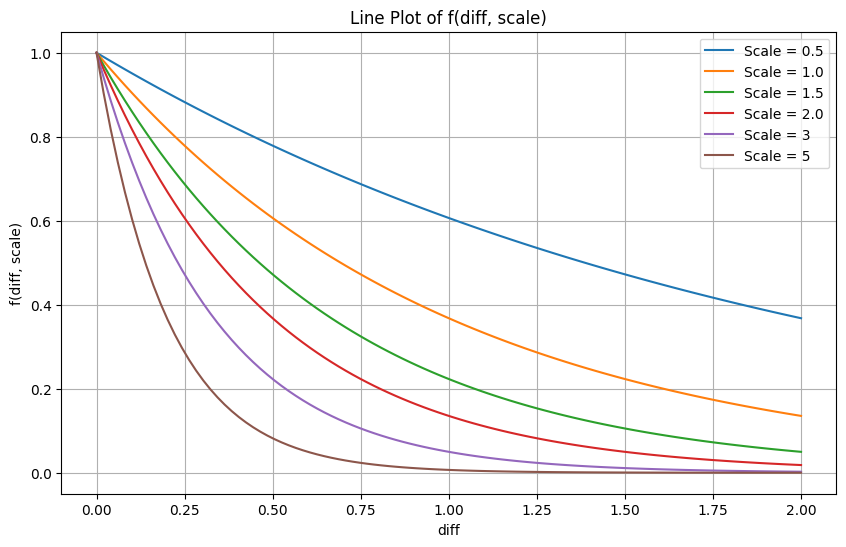

In [4]:
diff_values = np.linspace(0, 2, 100)
def f(diff, scale):
    return np.exp(-scale * diff)
scales = [0.5, 1.0, 1.5, 2.0, 3, 5]
plt.figure(figsize=(10, 6))
for i, scale in enumerate(scales):
    sns.lineplot(x=diff_values, y=f(diff_values, scale), label=f'Scale = {scale}')
# sns.lineplot(x=diff_values, y=1-diff_values, label='Line')
plt.title('Line Plot of f(diff, scale)')
plt.xlabel('diff')
plt.ylabel('f(diff, scale)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some example data
time = [1, 2, 3, 4, 5]
score = [4, 5, 6, 5, 7]
accuracy = [0.8, 0.7, 0.9, 0.6, 0.5]

# Create a new figure and axis
fig, ax1 = plt.subplots()

# Plot the score data against time on the first y-axis
sns.lineplot(x=time, y=score, ax=ax1, label='Score', color='blue')

# Set the label and color of the first y-axis
ax1.set_ylabel('Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis and plot the accuracy data against time on it
ax2 = ax1.twinx()
sns.lineplot(x=time, y=accuracy, ax=ax2, label='Accuracy', color='red')

# Set the label and color of the second y-axis
ax2.set_ylabel('Accuracy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the x-axis label and plot title
ax1.set_xlabel('Time')
plt.title('Score and Accuracy over Time')

# Display the plot
plt.show()


AttributeError: 'Figure' object has no attribute 'items'

In [11]:
x = jnp.arange(10).reshape(2, 5)
y = jnp.tile(x, (2, 1))
z = jnp.repeat(x, 2, 0)
print(y)
print(z)

[[0 1 2 3 4]
 [5 6 7 8 9]
 [0 1 2 3 4]
 [5 6 7 8 9]]
[[0 1 2 3 4]
 [0 1 2 3 4]
 [5 6 7 8 9]
 [5 6 7 8 9]]
